In [1]:
import os
import sys

In [2]:
os.getcwd()

'/workspace'

In [3]:
HOMEDIR = os.getcwd()
if "jovyan" in HOMEDIR:
    HOMEDIR = "/home/jovyan/sivtsov/graph_agent"

In [4]:
# crutch for code visibiltiy
sys.path.append(HOMEDIR)

In [5]:
STARPU_HOME = HOMEDIR

# Inspect

here you can dump whole graph, to see how it looks like. It is traced from nntile model (which created from pytorch). So operations should be as in original model (there are tests)

In [12]:
import os
import json
from subprocess import Popen, PIPE
from simulator.nnt_graph_sched_utils import (
    BufferizedIterator, 
    StreamGraphLinesCatcher,
    GraphParser,
    SchedulerTaskGraph,
    TimingsParser,
    PrioritySerializer
)

In [13]:
from graph_trainer import (
    construct_program_cmd,
    custom_dynamic_policy, 
    custom_random_policy,
    GraphRunner
)

In [14]:
file = f"{HOMEDIR}/graph_tracer/traced_graph_2_small_layers.json"
ncpus = 1
ncuda = 0
niters = 1
manual_sampling = False

verbose = True

gr = GraphRunner(file, ncpus, ncuda, niters, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=False, starpu_home=STARPU_HOME)

Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_2_small_layers.json --ncpus 1 --ncuda 0 --niters 1
Process pid: 7942


In [15]:
_ = gr.skip_initialization_routine()
graph_init = gr.next()

In [16]:
# https://graphviz.org/
gi_gv = graph_init.to_graphviz()

In [17]:
gi_gv.render(f"{HOMEDIR}/small.dot")

'/workspace/small.dot.pdf'

# Slice the graph

For better convergence, debug and replay buffer purposes, you have the ability to provide slice indicies for graph

Note, you should use interactive mode 

In [18]:
file = f"{HOMEDIR}/graph_tracer/traced_graph_2_small_layers.json"
ncpus = 1
ncuda = 0
niters = 1
manual_sampling = True

verbose = True

gr = GraphRunner(file, ncpus, ncuda, niters, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=False, starpu_home=STARPU_HOME)

Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_2_small_layers.json --ncpus 1 --ncuda 0 --niters 1 --manual_sampling
Process pid: 8005


In [19]:
with open(file, "r") as f:
    config = json.load(f)

operations = config["calls"]
total_operations = len(operations)
total_operations

141

In [20]:
_ = gr.skip_initialization_routine()

In [21]:
graph_slice = gr.next([50,60])

In [22]:
# note that where are actually also initialization ops 
len(graph_slice.nodes)

14

# Collect statistics

First, you need to simulate graph multiple times to collect starpu statistics (nntile based on starpu)   
It will give you timings for every operation in graph

Note, they are statistically collected and will not be updated during next simulations runs. So you can't train on them. 

In [208]:
file = f"{HOMEDIR}/graph_tracer/traced_graph_8_layers.json"
ncpus = 4
ncuda = 0
niters = 25
manual_sampling = False

verbose = True

gr = GraphRunner(file, ncpus, ncuda, niters, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=False, collect_metrics=True)

Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_8_layers.json --ncpus 4 --ncuda 0 --niters 25
Process pid: 60966


In [209]:
# just wait until finished. 
# For now because of crutch nature of trainer, it can give bad result code
gr.p.wait()

-6

In [25]:
for l in gr.stderr_iter:
    pass

for l in gr.stdout_iter:
    pass

In [26]:
# But if all iterations completed - should be fine
gr.stderr_iter.buffer[-50:]

[b'__STEP__ Start-20-------------------------------\n',
 b'Sched_SyncTime: 2943149141975\n',
 b'Finish------------------------------\n',
 b'__STEP__ Start-21-------------------------------\n',
 b'Sched_SyncTime: 2943813137066\n',
 b'Finish------------------------------\n',
 b'__STEP__ Start-22-------------------------------\n',
 b'Sched_SyncTime: 2944460075962\n',
 b'Finish------------------------------\n',
 b'__STEP__ Start-23-------------------------------\n',
 b'Sched_SyncTime: 2945248117617\n',
 b'Finish------------------------------\n',
 b'__STEP__ Start-24-------------------------------\n',
 b'Sched_SyncTime: 2945955161672\n',
 b'Finish------------------------------\n',
 b'/workspace/starpu-1.4.7/install/starpu-1.4.7/lib/libstarpu-1.4.so.6(_starpu_task_submit+0x6c2)[0x7f0b8d3e4dc2]\n',
 b'/workspace/starpu-1.4.7/install/starpu-1.4.7/lib/libstarpu-1.4.so.6(+0x612b0)[0x7f0b8d3fe2b0]\n',
 b'/workspace/starpu-1.4.7/install/starpu-1.4.7/lib/libstarpu-1.4.so.6(starpu_data_release_to_on

# Baseline Agent

here I suggest you to decouple some logic   

In [182]:
class BaselineAgent:
    def __init__(self, strategy="random", device="cpu"):
        """
        here you can store actual model
        and history of this agent (maybe resent, not whole)
        """
        # self.agent_decisions = []
        self.strategy = strategy
        self.device = device

    def schedule(self, graph):
        """
        Here you just schedule train
        Don't do expensive grapdient/state computations, just simulation step
        """
        # custom_dynamic_policy/custom_random_policy. Look at graph_trainer.py
        # First baseline you should beat is custom_random_policy. Because even simplest DFS is better
        # Second - custom_dynamic_policy - DFS like approach. 
        # Probably you will just learn this strategy with your agent for now. 
        # To beat it, graph should be more complex, not strategy
        if self.strategy=="dynamic":
            custom_dynamic_policy(i, graph, strategy=self.device)
        elif self.strategy=="random":
            custom_random_policy(i, graph, strategy=self.device)
        else:
            raise Exception("No such baseline")

class AgentTrainer:
    def __init__(self):
        # self.optimizer = optimizer
        # self.replay_buffer = replay_buffer
        pass
    
    def step(self, graph, agent, timing):
        """
        Called after getting timings from your agent decision
        Here you can maintain optimizer states, compute grads, backpropagate and so on
        Probably - here can be stored state for RL algos like replay buffer
        """
        # Called after 
        pass

## Baseline runs

In [218]:
file = f"{HOMEDIR}/graph_tracer/traced_graph_8_layers.json"
ncpus = 4
ncuda = 0
niters = 10
manual_sampling = True

verbose = True
# verbose = False

In [197]:
with open(file, "r") as f:
    config = json.load(f)

operations = config["calls"]
total_operations = len(operations)
total_operations

531

In [219]:
agent = BaselineAgent(strategy="dynamic", device="cpu" if ncuda==0 else "mixed")
trainer = AgentTrainer()

In [220]:
gr = GraphRunner(file, ncpus, ncuda, niters, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=True, starpu_home=STARPU_HOME)
_ = gr.skip_initialization_routine()

Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_8_layers.json --ncpus 4 --ncuda 0 --niters 10 --manual_sampling
Process pid: 64740


In [221]:
rng = np.random.default_rng()

In [ ]:
timings_true_dynamic = []

for i in range(gr.niters):
    inds = "all" # just use this if you want whole graph
    print(f"{i=} {inds=}")
    graph = gr.next(inds=inds)

    agent.schedule(graph)

    gr.serialize_priorities(graph)
    timings = gr.wait_get_timings()
    timings_true_dynamic.append(timings)
    trainer.step(graph, agent, timings)

i=0 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21855297913498, t_end=21870403823786, delta_ms=15105.910288
i=1 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21870417465335, t_end=21885748109772, delta_ms=15330.644437
i=2 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21885764850208, t_end=21900546102351, delta_ms=14781.252143
i=3 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21900633843902, t_end=21915611493314, delta_ms=14977.649412
i=4 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21915629019976, t_end=21930154373349, delta_ms=14525.353373
i=5 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21930173309224, t_end=21944833647159, delta_ms=14660.337935
i=6 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21944849285515, t_end=21959534611500, delta_ms=14685.325985
i=7 in

In [211]:
agent = BaselineAgent(strategy="random", device="cpu" if ncuda==0 else "mixed")
trainer = AgentTrainer()

In [212]:
gr = GraphRunner(file, ncpus, ncuda, niters, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=True, starpu_home=STARPU_HOME)
_ = gr.skip_initialization_routine()

Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_8_layers.json --ncpus 4 --ncuda 0 --niters 20 --manual_sampling
Process pid: 63947


In [213]:
timings_random = []

for i in range(gr.niters):
    # inds = get_subset_inds(rng, total_operations)
    inds = "all" # just use this if you want whole graph
    print(f"{i=} {inds=}")
    graph = gr.next(inds=inds)

    # print("Nodes: ", len(graph.nodes))

    agent.schedule(graph)

    gr.serialize_priorities(graph)
    timings = gr.wait_get_timings()

    trainer.step(graph, agent, timings)
    
    timings_random.append(timings)

i=0 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21590274345581, t_end=21604764704689, delta_ms=14490.359108
i=1 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21604778005477, t_end=21619221510780, delta_ms=14443.505303
i=2 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21619237923855, t_end=21633938185682, delta_ms=14700.261827
i=3 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21633954850564, t_end=21648314031026, delta_ms=14359.180462
i=4 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21648329067878, t_end=21662711823858, delta_ms=14382.75598
i=5 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21662723168411, t_end=21677077796835, delta_ms=14354.628424
i=6 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=21677095281237, t_end=21691430786998, delta_ms=14335.505761
i=7 ind

KeyboardInterrupt: 

# Simple RL (Predicts device type)

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.optim as optim
import numpy as np
import copy


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        # action_dim = 2 (0: CPU, 1: CUDA)

        # Общая часть сети
        self.shared_layer = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        # Actor - предсказывает вероятности действий (выбор устройства)
        self.actor_head = nn.Linear(128, action_dim)

        # Critic - предсказывает ценность состояния
        self.critic_head = nn.Linear(128, 1)

    def forward(self, state):
        x = self.shared_layer(state)
        action_logits = self.actor_head(x)
        state_value = self.critic_head(x)
        return action_logits, state_value

# Хранилище для опыта PPO (траекторий одного эпизода/графа)
# PPOBuffer будет хранить данные *многих* эпизодов для обновления
class PPOBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.rewards = []
        self.values = []
        self.dones = []
        self.terminals = []

    def store(self, state, action, log_prob, value, reward, done, terminal):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)
        self.terminals.append(terminal)

    def clear(self):
        del self.states[:]
        del self.actions[:]
        del self.log_probs[:]
        del self.rewards[:]
        del self.values[:]
        del self.dones[:]
        del self.terminals[:]

    def __len__(self):
        return len(self.states)


GLOBAL_PRIO = 1000000000

class PPOAgent:
    def __init__(self, state_dim, action_dim=2, lr_actor=3e-4, lr_critic=1e-3, gamma=0.99, K_epochs=80, eps_clip=0.2, device="cpu", n_cpus=4, n_gpus=0):
        self.device = torch.device(device)
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.n_cpus = n_cpus
        self.n_gpus = n_gpus
        self.action_dim = action_dim # 0: CPU, 1: CUDA

        self.policy = ActorCritic(state_dim, action_dim).to(self.device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.shared_layer.parameters(), 'lr': lr_actor},
                        {'params': self.policy.actor_head.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic_head.parameters(), 'lr': lr_critic}]
                    )

        self.policy_old = ActorCritic(state_dim, action_dim).to(self.device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.episode_buffer = {'states': [], 'actions': [], 'log_probs': [], 'values': []}

        self.global_prio_counter = GLOBAL_PRIO

        self.MseLoss = nn.MSELoss()

    def _get_state(self, node):
        """Преобразует узел графа в вектор состояния."""
        # Пример простого состояния:
        # 1. Среднее время CPU (или большое значение, если нет)
        # 2. Среднее время CUDA (или большое значение, если нет)
        # 3. Количество CPU воркеров
        # 4. Количество CUDA воркеров
        # 5. Количество входящих зависимостей
        # 6. Количество исходящих зависимостей

        cpu_times = [pm.length_mcs for pm in node.perfmodels if pm.worker_type == 'CPU']
        cuda_times = [pm.length_mcs for pm in node.perfmodels if pm.worker_type == 'CUDA']

        avg_cpu_time = np.mean(cpu_times) if cpu_times else 1e9
        avg_cuda_time = np.mean(cuda_times) if cuda_times else 1e9

        n_cpu_perf = len(cpu_times)
        n_cuda_perf = len(cuda_times)
        n_in = len(node.inc)
        n_out = len(node.out)

        state = np.array([avg_cpu_time, avg_cuda_time, n_cpu_perf, n_cuda_perf, n_in, n_out], dtype=np.float32)
        return state

    def select_action(self, state, node):
        """Выбирает действие (устройство) для узла на основе текущего состояния."""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(self.device)
            action_logits, state_value = self.policy_old(state_tensor)

        dist = Categorical(logits=action_logits)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)

        self.episode_buffer['states'].append(state)
        self.episode_buffer['actions'].append(action.item())
        self.episode_buffer['log_probs'].append(action_log_prob.item())
        self.episode_buffer['values'].append(state_value.item())

        return action.item()

    def schedule(self, graph):
        """Планирует выполнение графа, выбирая устройство для каждого узла."""
        self.episode_buffer = {'states': [], 'actions': [], 'log_probs': [], 'values': []}
        self.global_prio_counter = GLOBAL_PRIO


        nodes_to_schedule = list(graph.nodes.items())

        for _, node in nodes_to_schedule:
            if node.name == 'NULL':
                continue

            state = self._get_state(node)

            action = self.select_action(state, node)

            node.prio = self.global_prio_counter
            self.global_prio_counter -= 1

            cpu_affinity = [pm.worker_type == 'CPU' for pm in node.perfmodels]
            cuda_affinity = [pm.worker_type == 'CUDA' for pm in node.perfmodels]

            has_cuda_workers = any(pm.worker_type == 'CUDA' for pm in node.perfmodels)
            if self.n_gpus == 0 or not has_cuda_workers:
                 action = 0 

            if action == 0:
                node.device_affinity = [c or False for c in cpu_affinity]
            elif action == 1:
                 node.device_affinity = [cu or False for cu in cuda_affinity]
            else:
                raise ValueError(f"Неизвестное действие: {action}")

            if not any(node.device_affinity):
                if action == 0 and any(cuda_affinity):
                    node.device_affinity = [cu or False for cu in cuda_affinity]
                elif action == 1 and any(cpu_affinity):
                     node.device_affinity = [c or False for c in cpu_affinity]
                else:
                     node.device_affinity = [True] * len(node.perfmodels)

    def update(self, buffer):
        """Обновляет веса сети с использованием данных из PPOBuffer."""
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(buffer.rewards), reversed(buffer.terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states = torch.stack([torch.from_numpy(s) for s in buffer.states]).to(self.device).detach()
        old_actions = torch.tensor(buffer.actions, dtype=torch.long).to(self.device).detach()
        old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32).to(self.device).detach()
        old_values = torch.tensor(buffer.values, dtype=torch.float32).to(self.device).detach()

        advantages = rewards - old_values.detach()
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)

        for _ in range(self.K_epochs):
            action_logits, state_values = self.policy(old_states)
            dist = Categorical(logits=action_logits)

            log_probs = dist.log_prob(old_actions)
            dist_entropy = dist.entropy()
            state_values = torch.squeeze(state_values)

            ratios = torch.exp(log_probs - old_log_probs.detach())

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages

            loss_actor = -torch.min(surr1, surr2).mean()

            loss_critic = 0.5 * self.MseLoss(state_values, rewards)

            loss_entropy = -0.01 * dist_entropy.mean()

            loss = loss_actor + loss_critic + loss_entropy

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())


def save(self, filepath):
    """Сохраняет веса модели."""
    print(f"Saving model to {filepath}...")
    torch.save(self.policy.state_dict(), filepath)
    print("Model saved.")

def load(self, filepath):
    """Загружает веса модели."""
    print(f"Loading model from {filepath}...")
    self.policy.load_state_dict(torch.load(filepath, map_location=lambda storage, loc: storage))
    self.policy_old.load_state_dict(self.policy.state_dict())
    print("Model loaded.")
    # Режим инференса
    # self.policy.eval()
    # self.policy_old.eval()
    self.policy.train()
    self.policy_old.train()

# Simple RL agent (predicts affinity)

This agent was used in plots from presentation

In [ ]:
# ppo_agent.py
import torch
import torch.nn as nn
from torch.distributions import Bernoulli
import torch.optim as optim
import numpy as np

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.shared_layer = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.actor_probs = nn.Linear(128, action_dim)

        self.critic_head = nn.Linear(128, 1)

    def forward(self, state):
        x = self.shared_layer(state)
        action_probs = torch.sigmoid(self.actor_probs(x))
        state_value = self.critic_head(x)
        return action_probs, state_value

GLOBAL_PRIO = 1000000000

class PPOAgent:
    def __init__(self, state_dim, num_cpu_cores, lr_actor=3e-4, lr_critic=1e-3, gamma=0.99, K_epochs=80, eps_clip=0.2, device="cpu", affinity_threshold=0.5):
        self.device = torch.device(device)
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.num_cpu_cores = num_cpu_cores
        self.action_dim = num_cpu_cores
        self.affinity_threshold = affinity_threshold
        self.MseLoss = nn.MSELoss()
        self.policy = ActorCritic(state_dim, self.action_dim).to(self.device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.shared_layer.parameters(), 'lr': lr_actor},
                        {'params': self.policy.actor_probs.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic_head.parameters(), 'lr': lr_critic}]
                    )

        self.policy_old = ActorCritic(state_dim, self.action_dim).to(self.device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.episode_buffer = {'states': [], 'actions': [], 'log_probs': [], 'values': []}

    def _get_state(self, node):
        """Преобразует узел графа в вектор состояния."""
        cpu_times = [pm.length_mcs for pm in node.perfmodels]
        avg_cpu_time = np.mean(cpu_times) if cpu_times else 1e9
        n_cpu_perf = len(cpu_times)
        n_in = len(node.inc)
        n_out = len(node.out)

        state = np.array([avg_cpu_time, n_cpu_perf, n_in, n_out, self.num_cpu_cores], dtype=np.float32)
        return state

    def select_action(self, state, node):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(self.device)
            action_probs, state_value = self.policy_old(state_tensor)

        dist = Bernoulli(action_probs)

        actions = dist.sample()
        log_probs = dist.log_prob(actions).sum()

        self.episode_buffer['states'].append(state)
        self.episode_buffer['actions'].append(actions.cpu().numpy())
        self.episode_buffer['log_probs'].append(log_probs.item())
        self.episode_buffer['values'].append(state_value.item())

        return actions.cpu().numpy()

    def schedule(self, graph):
        self.global_prio_counter = GLOBAL_PRIO
        self.episode_buffer = {'states': [], 'actions': [], 'log_probs': [], 'values': []}

        nodes_to_schedule = list(graph.nodes.items())

        for _, node in nodes_to_schedule:
            if node.name == 'NULL':
                continue

            state = self._get_state(node)

            core_selection = self.select_action(state, node)

            device_affinity = []
            for i, pm in enumerate(node.perfmodels):
                if pm.worker_type:
                    core_index = int(pm.workerid)

                    if core_index < self.num_cpu_cores and core_selection[core_index] >= self.affinity_threshold:
                        device_affinity.append(True)
                    else:
                        device_affinity.append(False)
                else:
                    device_affinity.append(False)

            if not any(device_affinity):
                cpu_affinity = [pm.worker_type == 'CPU' for pm in node.perfmodels]
                device_affinity = [c or False for c in cpu_affinity]
                if not any(device_affinity):
                    device_affinity = [True] * len(node.perfmodels)

            node.device_affinity = device_affinity

            node.prio = self.global_prio_counter
            self.global_prio_counter -= 1

    def update(self, buffer):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(buffer.rewards), reversed(buffer.terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        old_states = torch.stack([torch.from_numpy(s) for s in buffer.states]).to(self.device).detach()
        old_actions = torch.tensor(np.stack(buffer.actions), dtype=torch.float32).to(self.device).detach()  # Stack numpy arrays
        old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32).to(self.device).detach()
        old_values = torch.tensor(buffer.values, dtype=torch.float32).to(self.device).detach()

        advantages = rewards - old_values.detach()
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)
        for _ in range(self.K_epochs):
            action_probs, state_values = self.policy(old_states)
            dist = Bernoulli(action_probs)
            log_probs = dist.log_prob(old_actions).sum(dim=1)
            dist_entropy = dist.entropy().mean()
            state_values = torch.squeeze(state_values)

            ratios = torch.exp(log_probs - old_log_probs.detach())

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            loss_actor = -torch.min(surr1, surr2).mean()
            loss_critic = 0.5 * self.MseLoss(state_values, rewards)

            loss = loss_actor + loss_critic - 0.01*dist_entropy
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()
        self.policy_old.load_state_dict(self.policy.state_dict())

In [ ]:
from collections import deque

class AgentTrainer:
    def __init__(self, agent, ppo_buffer, gamma=0.99, update_timestep=2000, log_interval=10): # agent - это PPOAgent
        self.agent = agent
        self.ppo_buffer = ppo_buffer
        self.gamma = gamma
        self.update_timestep = update_timestep
        self.log_interval = log_interval
        self.timestep_counter = 0
        self.episode_reward = 0
        self.episode_length = 0
        self.episodes = 0

        self.reward_queue = deque(maxlen=100)
        self.length_queue = deque(maxlen=100)

    def step(self, graph, timings, inds):
        """
        Выполняется после получения таймингов от выполнения графа.
        Вычисляет награду, сохраняет опыт в буфер и обновляет агента.
        """

        reward = -timings
        self.episode_reward += reward

        done = True
        terminal = True

        states = self.agent.episode_buffer['states']
        actions = self.agent.episode_buffer['actions']
        log_probs = self.agent.episode_buffer['log_probs']
        values = self.agent.episode_buffer['values']

        if not (len(states) == len(actions) == len(log_probs) == len(values)):
            print("WARNING: Длины states, actions, log_probs, values не совпадают!")
            print(f"{len(states)=}, {len(actions)=}, {len(log_probs)=}, {len(values)=}")

        for state, action, log_prob, value in zip(states, actions, log_probs, values):
            self.ppo_buffer.store(state, action, log_prob, value, reward, done, terminal)
            self.timestep_counter += 1
            self.episode_length += 1

        if self.timestep_counter >= self.update_timestep:
            self.agent.update(self.ppo_buffer)
            self.ppo_buffer.clear()
            self.timestep_counter = 0

        if done:
            self.episodes += 1
            self.reward_queue.append(self.episode_reward)
            self.length_queue.append(self.episode_length)
            avg_reward = sum(self.reward_queue) / len(self.reward_queue)
            avg_length = sum(self.length_queue) / len(self.length_queue)

            if self.episodes % self.log_interval == 0:
                print(f"Episode {self.episodes}: Reward = {self.episode_reward:.2f}, Avg Reward = {avg_reward:.2f}, Length = {self.episode_length}, Avg Length = {avg_length:.2f}")

            self.episode_reward = 0
            self.episode_length = 0

# Simple RL(affinity) runs


In [228]:
from graph_trainer import (
    construct_program_cmd,
    custom_dynamic_policy, 
    custom_random_policy,
    GraphRunner
)

from interpretator import (
    get_subset_inds
)

import json
import numpy as np

In [ ]:
state_dim = 5
file = f"{HOMEDIR}/graph_tracer/traced_graph_8_layers.json"
ncpus = 4
ncuda = 0
niters = 20
manual_sampling = True
verbose = True
with open(file, "r") as f:
    config = json.load(f)

operations = config["calls"]
total_operations = len(operations)
print(total_operations)
agent = PPOAgent(state_dim=5, device="cpu" if ncuda==0 else "cuda", num_cpu_cores=ncpus)
ppo_buffer = PPOBuffer()
trainer = AgentTrainer(agent, ppo_buffer, update_timestep=total_operations)
gr = GraphRunner(file, ncpus, ncuda, niters, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=True, starpu_home=STARPU_HOME)
_ = gr.skip_initialization_routine()
rng = np.random.default_rng()
timings_rl_basic = []
for i in range(gr.niters):
    inds = "all"
    print(f"{i=} {inds=}")
    graph = gr.next(inds=inds)


    agent.schedule(graph)

    gr.serialize_priorities(graph)
    timings = gr.wait_get_timings()

    trainer.step(graph, timings, inds)

    timings_rl_basic.append(timings)

531
Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_8_layers.json --ncpus 4 --ncuda 0 --niters 20 --manual_sampling
Process pid: 66338
i=0 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=22392412086781, t_end=22407280448842, delta_ms=14868.362061
i=1 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=22407658923278, t_end=22422086708053, delta_ms=14427.784775
i=2 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=22422410800136, t_end=22436742478410, delta_ms=14331.678274
i=3 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=22437127643720, t_end=22451740922362, delta_ms=14613.278642
i=4 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=22467319061915, t_end=22482407578589, delta_ms=15088.516674
i=5 inds='all'
n_nodes: 535 serialized: 534
Wait timings
Compute timings: t_begin=22482696294129, t_end=22497

# Enhanced RL agent (V1)

This agent uses Bernoulli distribution for choosing using devices.
Also it receives reward from every prediction for operation (-operation_time)

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Bernoulli
import torch.optim as optim
import numpy as np

GLOBAL_PRIO = 10**9

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.actor = nn.Linear(128, action_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        h = self.shared(x)
        return torch.sigmoid(self.actor(h)), self.critic(h)


class EnhancedPPOAgent:
    def __init__(self, graph, num_cores,
                 lr_actor=3e-4, lr_critic=1e-3,
                 gamma=0.99, eps_clip=0.2, K_epochs=20,
                 device="cpu", affinity_th=0.5):
        self.device = torch.device(device)
        self.num_cores = num_cores
        self.gamma, self.eps_clip, self.K_epochs = gamma, eps_clip, K_epochs
        self.aff_th = affinity_th

        self._prepare_graph_stats(graph) 

        # размер состояния: [depth, height, in_ready, out_unfin, bottom] + loads + norm_times
        state_dim = 5 + self.num_cores + self.num_cores 
        self.policy = ActorCritic(state_dim, self.num_cores).to(self.device)
        self.policy_old = ActorCritic(state_dim, self.num_cores).to(self.device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.optimizer = optim.Adam([
            {'params': self.policy.shared.parameters(), 'lr': lr_actor},
            {'params': self.policy.actor.parameters(),  'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])
        self.MseLoss = nn.MSELoss()

        self.buffer = {
            'states': [], 'actions': [], 'logps': [],
            'values': [], 'rewards': [], 'terms': []
        }
        self.device_loads = np.zeros(self.num_cores, dtype=np.float32) 
        self.prio_ctr = GLOBAL_PRIO


    def _prepare_graph_stats(self, graph):
        topo_sorted_nodes = list(graph.nodes.values()) 


        self.depth = {}
        for n in topo_sorted_nodes:
            if not n.inc:
                self.depth[n.addr] = 0
            else:
                max_parent_depth = 0
                for p_node in n.inc:
                    if p_node in self.depth:
                         max_parent_depth = max(max_parent_depth, self.depth[p_node])
                self.depth[n.addr] = max_parent_depth + 1
        
        self.height, self.bottom = {}, {}
        for n in reversed(topo_sorted_nodes):
            node_perf_times = [pm.length_mcs for pm in n.perfmodels if pm.worker_type == 'CPU'] # Рассматриваем только CPU времена для bottom level
            current_node_max_time = max(node_perf_times) if node_perf_times else 0.0

            if not n.out:
                self.height[n.addr] = 0
                self.bottom[n.addr] = current_node_max_time
            else:
                max_child_height = 0
                max_child_bottom_level = 0
                for c_node in n.out:
                    if c_node in self.height:
                        max_child_height = max(max_child_height, self.height[c_node])
                        max_child_bottom_level = max(max_child_bottom_level, self.bottom[c_node])

                self.height[n.addr] = max_child_height + 1
                self.bottom[n.addr] = current_node_max_time + max_child_bottom_level


    def reset(self):
        for k in self.buffer: self.buffer[k].clear()
        self.device_loads.fill(0)
        self.prio_ctr = GLOBAL_PRIO


    def _get_state(self, node, scheduled_nodes_count, graph):
        d = self.depth.get(node, 0)
        h = self.height.get(node, 0)
        
        in_ready = sum(1 for p in graph.nodes[node].inc if p in self.scheduled_this_episode) 
        
        out_unf = sum(1 for c in graph.nodes[node].out if c not in self.scheduled_this_episode)
        bl = self.bottom.get(node, 0)

        cpu_exec_times = np.full(self.num_cores, 1e9, dtype=np.float32)
        for pm in graph.nodes[node].perfmodels:
            if pm.worker_type == 'CPU':
                core_idx = int(pm.workerid)
                if 0 <= core_idx < self.num_cores:
                    cpu_exec_times[core_idx] = pm.length_mcs
        
        valid_cpu_times = cpu_exec_times[cpu_exec_times < 1e9]
        max_exec_time = valid_cpu_times.max() if len(valid_cpu_times) > 0 else 1.0
        if max_exec_time == 0: max_exec_time = 1.0
        t_norm = cpu_exec_times / (max_exec_time + 1e-9)

        current_max_load = self.device_loads.max()
        l_norm = self.device_loads / (current_max_load + 1e-9) if current_max_load > 0 else np.zeros_like(self.device_loads)
        s_vector = np.concatenate([[d, h, in_ready, out_unf, bl], l_norm, t_norm]).astype(np.float32)
        return torch.from_numpy(s_vector).float().to(self.device)


    def select_action(self, state_tensor):
        with torch.no_grad():
            probs, val = self.policy_old(state_tensor)
        dist = Bernoulli(probs)
        action_sample = dist.sample()
        return action_sample, dist.log_prob(action_sample).sum(), val.squeeze()


    def schedule(self, graph):
        self.reset()
        self.scheduled_this_episode = set()

        nodes_to_schedule = list(graph.nodes.values())
        

        for node_idx, node in enumerate(nodes_to_schedule):
            if node.name == 'NULL':
                continue

            state_tensor = self._get_state(node.addr, len(self.scheduled_this_episode), graph)
            
            action_mask_tensor, log_prob, value_pred = self.select_action(state_tensor)
            action_mask_cpu = action_mask_tensor.cpu().numpy().astype(bool)

            node_core_specific_exec_times = np.zeros(self.num_cores, dtype=np.float32)
            
            current_node_affinity = []
            selected_any_core_by_agent = False
            for pm_idx, pm in enumerate(node.perfmodels):
                assigned_to_this_pm = False
                if pm.worker_type == 'CPU':
                    core_idx = int(pm.workerid)
                    if 0 <= core_idx < self.num_cores and action_mask_cpu[core_idx]:
                        assigned_to_this_pm = True
                        selected_any_core_by_agent = True
                        node_core_specific_exec_times[core_idx] = pm.length_mcs
                current_node_affinity.append(assigned_to_this_pm)
            
            if not selected_any_core_by_agent:
                current_node_affinity_fallback = []
                any_cpu_in_fallback = False
                for pm in node.perfmodels:
                    if pm.worker_type == 'CPU':
                        current_node_affinity_fallback.append(True)
                        any_cpu_in_fallback = True
                    else:
                        current_node_affinity_fallback.append(False) 
                
                if any_cpu_in_fallback:
                    node.device_affinity = current_node_affinity_fallback
                elif node.perfmodels:
                     node.device_affinity = [True] * len(node.perfmodels)
                else:
                     node.device_affinity = []

            else:
                node.device_affinity = current_node_affinity

            node.prio = self.prio_ctr
            self.prio_ctr -= 1
            self.scheduled_this_episode.add(node.addr)


            prev_makespan_prediction = self.device_loads.max()
            self.device_loads += node_core_specific_exec_times
            current_makespan_prediction = self.device_loads.max()
            reward = -(current_makespan_prediction - prev_makespan_prediction)

            self.buffer['states'].append(state_tensor)
            self.buffer['actions'].append(action_mask_tensor)
            self.buffer['logps'].append(log_prob)
            self.buffer['values'].append(value_pred)
            self.buffer['rewards'].append(reward)
            self.buffer['terms'].append(False) 

        if self.buffer['terms']:
            self.buffer['terms'][-1] = True
        
    def finalize_episode_rewards(self, actual_makespan: float):
        if not self.buffer['rewards']:
            print("Warning: Finalize_episode_rewards вызван с пустым буффером наград.")
            return

        final_reward = -float(actual_makespan)
        self.buffer['rewards'][-1] = final_reward
        
        if self.buffer['terms'] and not self.buffer['terms'][-1]:
            self.buffer['terms'][-1] = True

    def update(self):
        if not self.buffer['states']:
            return

        discounted_rewards_to_go = []
        cumulative_reward = 0
        
        for r, is_terminal in zip(reversed(self.buffer['rewards']), reversed(self.buffer['terms'])):
            if is_terminal:
                cumulative_reward = 0
            cumulative_reward = r + (self.gamma * cumulative_reward)
            discounted_rewards_to_go.insert(0, cumulative_reward)
        
        rewards_tensor = torch.tensor(discounted_rewards_to_go, dtype=torch.float32, device=self.device)
        
        rewards_tensor = (rewards_tensor - rewards_tensor.mean()) / (rewards_tensor.std() + 1e-7)

        old_states_tensor = torch.stack(self.buffer['states']).detach()
        old_actions_tensor = torch.stack(self.buffer['actions']).detach()
        old_log_probs_tensor = torch.stack(self.buffer['logps']).detach()
        old_values_tensor = torch.stack(self.buffer['values']).detach()

        advantages = rewards_tensor - old_values_tensor
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)

        for _ in range(self.K_epochs):
            action_probs, state_values_pred = self.policy(old_states_tensor)
            dist = Bernoulli(action_probs)
            
            current_log_probs = dist.log_prob(old_actions_tensor).sum(dim=1)
            
            state_values_pred = state_values_pred.squeeze()
            
            ratios = torch.exp(current_log_probs - old_log_probs_tensor)

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            
            loss_actor = -torch.min(surr1, surr2).mean()
            loss_critic = self.MseLoss(state_values_pred, rewards_tensor)
            
            dist_entropy = dist.entropy().mean()
            
            loss = loss_actor + 0.5 * loss_critic - 0.1 * dist_entropy

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())
        


## Enhanced RL Agent (V2)

This agent uses logits and categorical distribution.  
Rewards are distributed using Generalized Advantage Estimation (GAE), also in agent was added loss coefficients (value function, entropy)

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Bernoulli
import torch.optim as optim
import numpy as np

GLOBAL_PRIO = 10**9

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.actor = nn.Linear(128, action_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        h = self.shared(x)
        action_logits = self.actor(h)
        value = self.critic(h)
        return action_logits, value


class EnhancedPPOAgent:
    def __init__(self, graph, num_cores,
                 lr_actor=3e-4, lr_critic=1e-3,
                 gamma=0.99, eps_clip=0.2, K_epochs=20,
                 device="cpu", affinity_th=0.5):
        self.device = torch.device(device)
        self.num_cores = num_cores
        self.gamma, self.eps_clip, self.K_epochs = gamma, eps_clip, K_epochs
        self.aff_th = affinity_th

        self._prepare_graph_stats(graph) 

        # размер состояния: [depth, height, in_ready, out_unfin, bottom] + loads + norm_times
        state_dim = 5 + self.num_cores + self.num_cores 
        self.policy = ActorCritic(state_dim, self.num_cores).to(self.device)
        self.policy_old = ActorCritic(state_dim, self.num_cores).to(self.device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.optimizer = optim.Adam([
            {'params': self.policy.shared.parameters(), 'lr': lr_actor},
            {'params': self.policy.actor.parameters(),  'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])
        self.MseLoss = nn.MSELoss() # Для critic loss

        self.buffer = {
            'states': [], 'actions': [], 'logps': [],
            'values': [], 'rewards': [], 'terms': []
        }
        self.device_loads = np.zeros(self.num_cores, dtype=np.float32) 
        self.prio_ctr = GLOBAL_PRIO


    def _prepare_graph_stats(self, graph):
        topo_sorted_nodes = list(graph.nodes.values()) 


        self.depth = {}
        for n in topo_sorted_nodes:
            if not n.inc:
                self.depth[n.addr] = 0
            else:
                max_parent_depth = 0
                for p_node in n.inc:
                    if p_node in self.depth:
                         max_parent_depth = max(max_parent_depth, self.depth[p_node])
                self.depth[n.addr] = max_parent_depth + 1
        
        self.height, self.bottom = {}, {}
        for n in reversed(topo_sorted_nodes):
            node_perf_times = [pm.length_mcs for pm in n.perfmodels if pm.worker_type == 'CPU'] # Рассматриваем только CPU времена для bottom level
            current_node_max_time = max(node_perf_times) if node_perf_times else 0.0

            if not n.out:
                self.height[n.addr] = 0
                self.bottom[n.addr] = current_node_max_time
            else:
                max_child_height = 0
                max_child_bottom_level = 0
                for c_node in n.out:
                    if c_node in self.height:
                        max_child_height = max(max_child_height, self.height[c_node])
                        max_child_bottom_level = max(max_child_bottom_level, self.bottom[c_node])

                self.height[n.addr] = max_child_height + 1
                self.bottom[n.addr] = current_node_max_time + max_child_bottom_level


    def reset(self):
        for k in self.buffer: self.buffer[k].clear()
        self.device_loads.fill(0)
        self.prio_ctr = GLOBAL_PRIO


    def _get_state(self, node, scheduled_nodes_count, graph):
        d = self.depth.get(node, 0)
        h = self.height.get(node, 0)
        
        in_ready = sum(1 for p in graph.nodes[node].inc if p in self.scheduled_this_episode) 
        
        out_unf = sum(1 for c in graph.nodes[node].out if c not in self.scheduled_this_episode)
        bl = self.bottom.get(node, 0)

        cpu_exec_times = np.full(self.num_cores, 1e9, dtype=np.float32)
        for pm in graph.nodes[node].perfmodels:
            if pm.worker_type == 'CPU':
                core_idx = int(pm.workerid)
                if 0 <= core_idx < self.num_cores:
                    cpu_exec_times[core_idx] = pm.length_mcs
        
        valid_cpu_times = cpu_exec_times[cpu_exec_times < 1e9]
        max_exec_time = valid_cpu_times.max() if len(valid_cpu_times) > 0 else 1.0
        if max_exec_time == 0: max_exec_time = 1.0
        t_norm = cpu_exec_times / (max_exec_time + 1e-9)

        current_max_load = self.device_loads.max()
        l_norm = self.device_loads / (current_max_load + 1e-9) if current_max_load > 0 else np.zeros_like(self.device_loads)
        s_vector = np.concatenate([[d, h, in_ready, out_unf, bl], l_norm, t_norm]).astype(np.float32)
        return torch.from_numpy(s_vector).float().to(self.device)


    def select_action(self, state_tensor):
        with torch.no_grad():
            action_logits, val = self.policy_old(state_tensor)

        dist = torch.distributions.Categorical(logits=action_logits)
        
        chosen_core_index = dist.sample()
        
        action_mask = torch.zeros_like(action_logits)
        
        if action_mask.ndim > 1:
             action_mask.scatter_(1, chosen_core_index.unsqueeze(-1), 1.0)
        else:
            action_mask[chosen_core_index] = 1.0
            
        log_prob = dist.log_prob(chosen_core_index)
        
        return action_mask, log_prob, val.squeeze()

    def schedule(self, graph):
        self.reset()
        self.scheduled_this_episode = set()

        nodes_to_schedule = list(graph.nodes.values())
        

        for node_idx, node in enumerate(nodes_to_schedule):
            if node.name == 'NULL':
                continue

            state_tensor = self._get_state(node.addr, len(self.scheduled_this_episode), graph)
            
            action_mask_tensor, log_prob, value_pred = self.select_action(state_tensor)
            action_mask_cpu = action_mask_tensor.cpu().numpy().astype(bool)

            node_core_specific_exec_times = np.zeros(self.num_cores, dtype=np.float32)
            
            current_node_affinity = []
            selected_any_core_by_agent = False
            for pm_idx, pm in enumerate(node.perfmodels):
                assigned_to_this_pm = False
                if pm.worker_type == 'CPU':
                    core_idx = int(pm.workerid)
                    if 0 <= core_idx < self.num_cores and action_mask_cpu[core_idx]:
                        assigned_to_this_pm = True
                        selected_any_core_by_agent = True
                        node_core_specific_exec_times[core_idx] = pm.length_mcs
                current_node_affinity.append(assigned_to_this_pm)
            
            if not selected_any_core_by_agent:
                current_node_affinity_fallback = []
                any_cpu_in_fallback = False
                for pm in node.perfmodels:
                    if pm.worker_type == 'CPU':
                        current_node_affinity_fallback.append(True)
                        any_cpu_in_fallback = True
                    else:
                        current_node_affinity_fallback.append(False) 
                
                if any_cpu_in_fallback:
                    node.device_affinity = current_node_affinity_fallback
                elif node.perfmodels:
                     node.device_affinity = [True] * len(node.perfmodels)
                else:
                     node.device_affinity = []

            else:
                node.device_affinity = current_node_affinity

            node.prio = self.prio_ctr
            self.prio_ctr -= 1
            self.scheduled_this_episode.add(node.addr)


            prev_makespan_prediction = self.device_loads.max()
            self.device_loads += node_core_specific_exec_times
            current_makespan_prediction = self.device_loads.max()
            reward = -(current_makespan_prediction - prev_makespan_prediction)

            self.buffer['states'].append(state_tensor)
            self.buffer['actions'].append(action_mask_tensor)
            self.buffer['logps'].append(log_prob)
            self.buffer['values'].append(value_pred)
            self.buffer['rewards'].append(reward)
            self.buffer['terms'].append(False) 

        if self.buffer['terms']:
            self.buffer['terms'][-1] = True
        
    def finalize_episode_rewards(self, actual_makespan: float):
        if not self.buffer['rewards']:
            print("Warning: Finalize_episode_rewards вызван с пустым буффером наград.")
            return

        final_reward = -float(actual_makespan)
        self.buffer['rewards'][-1] = final_reward
        
        if self.buffer['terms'] and not self.buffer['terms'][-1]:
            self.buffer['terms'][-1] = True

    def update(self):
        if not self.buffer['states']:
            return

        discounted_rewards_to_go = []
        cumulative_reward = 0
        
        for r, is_terminal in zip(reversed(self.buffer['rewards']), reversed(self.buffer['terms'])):
            if is_terminal:
                cumulative_reward = 0
            cumulative_reward = r + (self.gamma * cumulative_reward)
            discounted_rewards_to_go.insert(0, cumulative_reward)
        
        rewards_tensor = torch.tensor(discounted_rewards_to_go, dtype=torch.float32, device=self.device)
        
        rewards_tensor = (rewards_tensor - rewards_tensor.mean()) / (rewards_tensor.std() + 1e-7)

        old_states_tensor = torch.stack(self.buffer['states']).detach()
        old_actions_tensor = torch.stack(self.buffer['actions']).detach()
        old_log_probs_tensor = torch.stack(self.buffer['logps']).detach()
        old_values_tensor = torch.stack(self.buffer['values']).detach()

        advantages = rewards_tensor - old_values_tensor
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)

        for _ in range(self.K_epochs):
            action_logits, values_pred = self.policy(old_states_tensor)
            dist = Categorical(logits=action_logits)
            
            old_actions_one_hot_tensor = torch.stack(self.buffer['actions']).to(self.device)
            old_action_indices = old_actions_one_hot_tensor.argmax(dim=-1)
            new_logps = dist.log_prob(old_action_indices)
            state_values_pred = values_pred.squeeze()
            
            ratios = torch.exp(new_logps - old_log_probs_tensor)

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            
            loss_actor = -torch.min(surr1, surr2).mean()
            loss_critic = self.MseLoss(state_values_pred, rewards_tensor)
            
            dist_entropy = dist.entropy().mean()
            
            loss = loss_actor + 0.5 * loss_critic - 0.1 * dist_entropy

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())

# Enhanced RL agent runs

In [ ]:
from graph_trainer import (
    construct_program_cmd,
    custom_dynamic_policy, 
    custom_random_policy,
    GraphRunner
)

from interpretator import (
    get_subset_inds
)

import json
import numpy as np
with open(file, "r") as f:
    config = json.load(f)

operations = config["calls"]
total_operations = len(operations)
total_operations
file = f"{HOMEDIR}/graph_tracer/traced_graph_32_small_layers.json"
ncpus = 4
ncuda = 0
niters = 20
manual_sampling = True
verbose = True
gr = GraphRunner(file, ncpus, ncuda, niters, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=True, starpu_home=STARPU_HOME)
_ = gr.skip_initialization_routine()
initial_graph_structure = gr.next(inds="all")

agent = EnhancedPPOAgent(graph=initial_graph_structure, num_cores=ncpus, device="cpu" if ncuda==0 else "cuda", K_epochs=10) # K_epochs можно уменьшить


episode_timings_log = []

for i in range(gr.niters):
    print(f"Episode {i+1}/{gr.niters}")
    if i == 0:
        graph_episode = initial_graph_structure
    else:
        graph_episode = gr.next(inds="all")
    print("Got graph")
    agent.schedule(graph_episode) 
    print("Scheduled graph")
    gr.serialize_priorities(graph_episode)
    diff_makespan = gr.wait_get_timings()
    agent.finalize_episode_rewards(diff_makespan)
    agent.update()
    episode_timings_log.append(diff_makespan)
    print(f"Episode {i+1}: Actual Makespan = {diff_makespan:.2f} ms")
    if (i+1) % 10 == 0:
        avg_makespan = np.mean(episode_timings_log[-100:])
        print(f"Average makespan over last {min(len(episode_timings_log), 100)} episodes: {avg_makespan:.2f} ms")

Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_32_small_layers.json --ncpus 4 --ncuda 0 --niters 20 --manual_sampling
Process pid: 45322
Episode 1/20
Got graph
Scheduled graph
n_nodes: 2095 serialized: 2094
Wait timings
Compute timings: t_begin=15332885066114, t_end=15338382939363, delta_ms=5497.873249
Episode 1: Actual Makespan = 5497.87 ms
Episode 2/20
Got graph
Scheduled graph
n_nodes: 2095 serialized: 2094
Wait timings
Compute timings: t_begin=15340726305618, t_end=15348710168080, delta_ms=7983.862462
Episode 2: Actual Makespan = 7983.86 ms
Episode 3/20
Got graph
Scheduled graph
n_nodes: 2095 serialized: 2094
Wait timings
Compute timings: t_begin=15349348203462, t_end=15357895004857, delta_ms=8546.801395
Episode 3: Actual Makespan = 8546.80 ms
Episode 4/20
Got graph
Scheduled graph
n_nodes: 2095 serialized: 2094
Wait timings
Compute timings: t_begin=15358510912551, t_end=15366884079286, delta_ms=8373.166735
Episode 4: Actual Makespan =

In [ ]:
torch.save(agent.policy.state_dict(), "enhanced_rl_agent_v1.pth")

# Enhanced RL agent v2 (enhanced rewards distribution)

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Bernoulli
import torch.optim as optim
import numpy as np

GLOBAL_PRIO = 10**9

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.actor = nn.Linear(128, action_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        h = self.shared(x)
        return torch.sigmoid(self.actor(h)), self.critic(h)


class EnhancedPPOAgentV2:
    def __init__(self, graph, num_cores,
                 lr_actor=3e-4, lr_critic=1e-3,
                 gamma=0.99, eps_clip=0.2, K_epochs=20,
                 device="cpu", affinity_th=0.5, lambda_gae=0.95, vf_coeff=0.5, entropy_coeff=0.01):
        self.device = torch.device(device)
        self.num_cores = num_cores
        self.gamma, self.eps_clip, self.K_epochs = gamma, eps_clip, K_epochs
        self.aff_th = affinity_th

        self._prepare_graph_stats(graph) 

        # размер состояния: [depth, height, in_ready, out_unfin, bottom] + loads + norm_times
        state_dim = 5 + self.num_cores + self.num_cores 
        self.policy = ActorCritic(state_dim, self.num_cores).to(self.device)
        self.policy_old = ActorCritic(state_dim, self.num_cores).to(self.device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.optimizer = optim.Adam([
            {'params': self.policy.shared.parameters(), 'lr': lr_actor},
            {'params': self.policy.actor.parameters(),  'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])
        self.lambda_gae = lambda_gae
        self.vf_coeff = vf_coeff
        self.entropy_coeff = entropy_coeff
        self.MseLoss = nn.MSELoss()

        self.buffer = {
            'states': [], 'actions': [], 'logps': [],
            'values': [], 'rewards': [], 'terms': []
        }
        self.device_loads = np.zeros(self.num_cores, dtype=np.float32) 
        self.prio_ctr = GLOBAL_PRIO


    def _prepare_graph_stats(self, graph):
        topo_sorted_nodes = list(graph.nodes.values()) 


        self.depth = {}
        for n in topo_sorted_nodes:
            if not n.inc:
                self.depth[n.addr] = 0
            else:
                max_parent_depth = 0
                for p_node in n.inc:
                    if p_node in self.depth:
                         max_parent_depth = max(max_parent_depth, self.depth[p_node])
                self.depth[n.addr] = max_parent_depth + 1
        
        self.height, self.bottom = {}, {}
        for n in reversed(topo_sorted_nodes):
            node_perf_times = [pm.length_mcs for pm in n.perfmodels if pm.worker_type == 'CPU'] # Рассматриваем только CPU времена для bottom level
            #print(n, node_perf_times)
            current_node_max_time = max(node_perf_times) if node_perf_times else 0.0

            if not n.out:
                self.height[n.addr] = 0
                self.bottom[n.addr] = current_node_max_time
            else:
                max_child_height = 0
                max_child_bottom_level = 0
                for c_node in n.out:
                    if c_node in self.height:
                        max_child_height = max(max_child_height, self.height[c_node])
                        max_child_bottom_level = max(max_child_bottom_level, self.bottom[c_node])

                self.height[n.addr] = max_child_height + 1
                self.bottom[n.addr] = current_node_max_time + max_child_bottom_level


    def reset(self):
        for k in self.buffer: self.buffer[k].clear()
        self.device_loads.fill(0)
        self.prio_ctr = GLOBAL_PRIO


    def _get_state(self, node, scheduled_nodes_count, graph):
        d = self.depth.get(node, 0)
        h = self.height.get(node, 0)
        
        in_ready = sum(1 for p in graph.nodes[node].inc if p in self.scheduled_this_episode) 
        
        out_unf = sum(1 for c in graph.nodes[node].out if c not in self.scheduled_this_episode)
        bl = self.bottom.get(node, 0)

        cpu_exec_times = np.full(self.num_cores, 1e9, dtype=np.float32)
        for pm in graph.nodes[node].perfmodels:
            if pm.worker_type == 'CPU':
                core_idx = int(pm.workerid)
                if 0 <= core_idx < self.num_cores:
                    cpu_exec_times[core_idx] = pm.length_mcs
        
        valid_cpu_times = cpu_exec_times[cpu_exec_times < 1e9]
        max_exec_time = valid_cpu_times.max() if len(valid_cpu_times) > 0 else 1.0
        if max_exec_time == 0: max_exec_time = 1.0
        t_norm = cpu_exec_times / (max_exec_time + 1e-9)

        current_max_load = self.device_loads.max()
        l_norm = self.device_loads / (current_max_load + 1e-9) if current_max_load > 0 else np.zeros_like(self.device_loads)
        s_vector = np.concatenate([[d, h, in_ready, out_unf, bl], l_norm, t_norm]).astype(np.float32)
        return torch.from_numpy(s_vector).float().to(self.device)


    def select_action(self, state_tensor):
        with torch.no_grad():
            probs, val = self.policy_old(state_tensor)
        dist = Bernoulli(probs)
        action_sample = dist.sample()
        return action_sample, dist.log_prob(action_sample).sum(), val.squeeze()


    def schedule(self, graph):
        self.reset()
        self.scheduled_this_episode = set()
        nodes_to_schedule = list(graph.nodes.values())
        

        for node_idx, node in enumerate(nodes_to_schedule):
            if node.name == 'NULL':
                continue

            state_tensor = self._get_state(node.addr, len(self.scheduled_this_episode), graph)
            
            action_mask_tensor, log_prob, value_pred = self.select_action(state_tensor)
            action_mask_cpu = action_mask_tensor.cpu().numpy().astype(bool)

            node_core_specific_exec_times = np.zeros(self.num_cores, dtype=np.float32)
            
            current_node_affinity = []
            selected_any_core_by_agent = False
            selected_timings = []
            for pm_idx, pm in enumerate(node.perfmodels):
                assigned_to_this_pm = False
                if pm.worker_type == 'CPU':
                    core_idx = int(pm.workerid)
                    if 0 <= core_idx < self.num_cores and action_mask_cpu[core_idx]:
                        assigned_to_this_pm = True
                        selected_any_core_by_agent = True
                        node_core_specific_exec_times[core_idx] = pm.length_mcs
                        selected_timings.append(pm.length_mcs)
                current_node_affinity.append(assigned_to_this_pm)
            
            if not selected_any_core_by_agent:
                current_node_affinity_fallback = []
                any_cpu_in_fallback = False
                for pm in node.perfmodels:
                    if pm.worker_type == 'CPU':
                        current_node_affinity_fallback.append(True)
                        any_cpu_in_fallback = True
                    else:
                        current_node_affinity_fallback.append(False) 
                
                if any_cpu_in_fallback:
                    node.device_affinity = current_node_affinity_fallback
                elif node.perfmodels:
                     node.device_affinity = [True] * len(node.perfmodels)
                else:
                     node.device_affinity = []

            else:
                node.device_affinity = current_node_affinity
            for pm_idx, pm in enumerate(node.perfmodels):
                assigned_to_this_pm = False
                if pm.worker_type == 'CPU':
                    try:
                        core_idx = int(pm.workerid)
                        if 0 <= core_idx < self.num_cores and action_mask_cpu[core_idx]:
                            assigned_to_this_pm = True
                            selected_any_core_by_agent = True
                            node_core_specific_exec_times[core_idx] = max(selected_timings)/len(selected_timings)
                    except (ValueError, TypeError):
                        pass
            node.prio = self.prio_ctr
            self.prio_ctr -= 1
            self.scheduled_this_episode.add(node.addr)


            prev_makespan_prediction = self.device_loads.max()
            self.device_loads += node_core_specific_exec_times
            current_makespan_prediction = self.device_loads.max()
            reward = -(current_makespan_prediction - prev_makespan_prediction)
            reward = 0
            self.buffer['states'].append(state_tensor)
            self.buffer['actions'].append(action_mask_tensor)
            self.buffer['logps'].append(log_prob)
            self.buffer['values'].append(value_pred)
            self.buffer['rewards'].append(reward)
            self.buffer['terms'].append(False) 

        if self.buffer['terms']:
            self.buffer['terms'][-1] = True
        
    def finalize_episode_rewards(self, diff_makespan: float):
        if not self.buffer['rewards']:
            print("Warning: Finalize_episode_rewards вызван с пустым буффером наград.")
            return

        final_reward = -float(diff_makespan)
        self.buffer['rewards'][-1] = final_reward
        
        if self.buffer['terms'] and not self.buffer['terms'][-1]:
            self.buffer['terms'][-1] = True

    def update(self):
        if not self.buffer['states']:
            print("Update called with empty buffer.")
            return

        try:
            states_tensor = torch.stack(self.buffer['states']).to(self.device).detach()
            
            actions_one_hot = torch.stack(self.buffer['actions']).to(self.device).detach()
            action_indices = actions_one_hot.argmax(dim=-1)

            old_logps_tensor = torch.stack(self.buffer['logps']).to(self.device).detach()
            rewards_tensor = torch.tensor(self.buffer['rewards'], dtype=torch.float32).to(self.device).detach()
            old_values_tensor = torch.stack(self.buffer['values']).to(self.device).detach().squeeze(-1)
            terms_tensor = torch.tensor(self.buffer['terms'], dtype=torch.float32).to(self.device).detach()
        except Exception as e:
            print(f"Error converting buffer to tensors: {e}")
            return

        if len(rewards_tensor) == 0:
            print("No rewards in buffer for update.")
            return

        advantages = torch.zeros_like(rewards_tensor).to(self.device)
        rewards_to_go = torch.zeros_like(rewards_tensor).to(self.device)
        
        last_gae_lam = 0
        running_return = 0

        for t in reversed(range(len(rewards_tensor))):
            if t == len(rewards_tensor) - 1:
                next_non_terminal = 1.0 - terms_tensor[t]
                next_value = 0
            else:
                next_non_terminal = 1.0 - terms_tensor[t+1]
                next_value = old_values_tensor[t+1]

            if terms_tensor[t]:
                delta = rewards_tensor[t] - old_values_tensor[t]
                last_gae_lam = delta
                running_return = rewards_tensor[t]
            else:
                delta = rewards_tensor[t] + self.gamma * next_value - old_values_tensor[t]
                last_gae_lam = delta + self.gamma * self.lambda_gae * last_gae_lam
                running_return = rewards_tensor[t] + self.gamma * running_return

            advantages[t] = last_gae_lam
            rewards_to_go[t] = running_return
            
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(self.K_epochs):
            action_logits_new, values_new_raw = self.policy(states_tensor)
            values_new = values_new_raw.squeeze(-1)
            
            dist_new = torch.distributions.Categorical(logits=action_logits_new)
            
            new_logps = dist_new.log_prob(action_indices)
            entropy = dist_new.entropy()

            ratio = torch.exp(new_logps - old_logps_tensor)

            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            
            critic_loss = self.MseLoss(values_new, rewards_to_go)
            
            loss = actor_loss + self.vf_coeff * critic_loss - self.entropy_coeff * entropy.mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())

        for k_buf in self.buffer: self.buffer[k_buf].clear()


# Enhanced agent V2 runs

In [ ]:
from graph_trainer import (
    construct_program_cmd,
    custom_dynamic_policy, 
    custom_random_policy,
    GraphRunner
)

from interpretator import (
    get_subset_inds
)

import json
import numpy as np
with open(file, "r") as f:
    config = json.load(f)

operations = config["calls"]
total_operations = len(operations)
total_operations
file = f"{HOMEDIR}/graph_tracer/traced_graph_8_layers.json"
ncpus = 4
ncuda = 0
niters = 20
manual_sampling = True
verbose = True
gr = GraphRunner(file, ncpus, ncuda, niters, manual_sampling, verbose=verbose, home_dir=HOMEDIR)
gr.run(interactive=True, starpu_home=STARPU_HOME)
_ = gr.skip_initialization_routine()
initial_graph_structure = gr.next(inds="all")

agent = EnhancedPPOAgentV2(graph=initial_graph_structure, num_cores=ncpus, device="cpu" if ncuda==0 else "cuda", K_epochs=10) # K_epochs можно уменьшить


episode_timings_log = []
s = 2
prev_makespan = np.mean(timings_true_dynamic[s:])
for i in range(gr.niters):
    print(f"Episode {i+1}/{gr.niters}")
    if i == 0:
        graph_episode = initial_graph_structure
    else:
        graph_episode = gr.next(inds="all")
    print("Got graph")
    agent.schedule(graph_episode) 
    print("Scheduled graph")
    gr.serialize_priorities(graph_episode)
    diff_makespan = gr.wait_get_timings()
    agent.finalize_episode_rewards(diff_makespan-prev_makespan)
    agent.update()
    episode_timings_log.append(diff_makespan)
    prev_makespan = min(prev_makespan, diff_makespan)
    print(diff_makespan)
    print(f"Episode {i+1}: Actual Makespan = {diff_makespan:.2f} ms")
    if (i+1) % 10 == 0:
        avg_makespan = np.mean(episode_timings_log[-100:])
        print(f"Average makespan over last {min(len(episode_timings_log), 100)} episodes: {avg_makespan:.2f} ms")

torch.save(agent.policy_old.state_dict(), "enhanced_ppo_agent_v2.pth")


Run process:  python3 /workspace/graph_dataset.py --file /workspace/graph_tracer/traced_graph_8_layers.json --ncpus 4 --ncuda 0 --niters 20 --manual_sampling
Process pid: 62475
GraphNode(name='NULL', addr=94725477312480, inc=[94725465690048], out=[], perfmodels=[], prio=None, device_affinity=None) []
GraphNode(name='NULL', addr=94725477311072, inc=[], out=[], perfmodels=[], prio=None, device_affinity=None) []
GraphNode(name='nntile_copy', addr=94725465690048, inc=[94725465686144], out=[94725477312480], perfmodels=[WorkerDevice(workerid='0', worker_type='CPU', length_mcs=99.03452), WorkerDevice(workerid='1', worker_type='CPU', length_mcs=99.03452), WorkerDevice(workerid='2', worker_type='CPU', length_mcs=99.03452), WorkerDevice(workerid='3', worker_type='CPU', length_mcs=99.03452)], prio=None, device_affinity=None) [99.03452, 99.03452, 99.03452, 99.03452]
GraphNode(name='nntile_prod_fiber3_fp32', addr=94725465686144, inc=[94725460443984, 94725465683376], out=[94725465690048], perfmodels

In [ ]:
pref = 2
s = pref if gr.niters > pref else 0 # if many iterations, consider frop warmup prefix

np.mean(timings_true_dynamic[s:]), np.mean(episode_timings_log[s:]), np.mean(episode_timings_log[s:])/np.mean(timings_true_dynamic[s:])

# Making plot

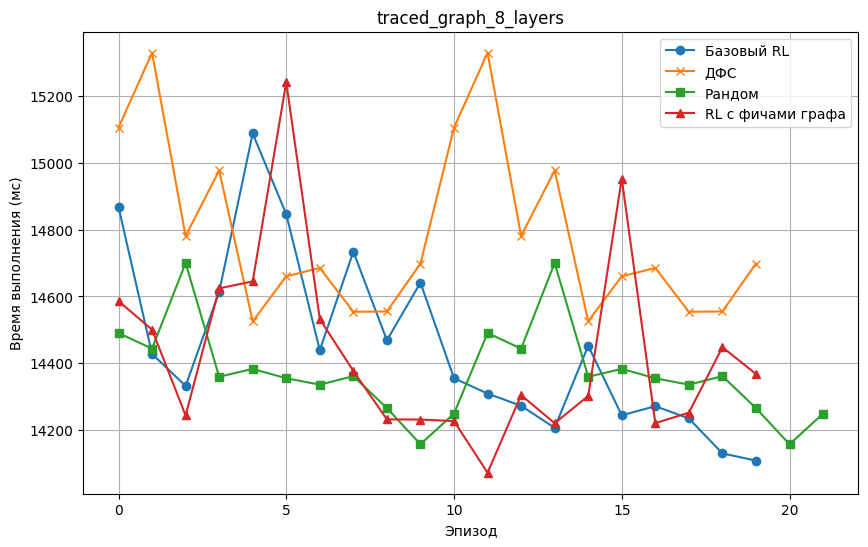

In [231]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 6))
plt.plot(timings_rl_basic, label='Базовый RL', marker='o')
plt.plot(timings_true_dynamic, label='ДФС', marker='x')
plt.plot(timings_random, label='Рандом', marker='s')
plt.plot(episode_timings_log, label='RL с фичами графа', marker='^')
plt.xlabel('Эпизод')
plt.ylabel('Время выполнения (мс)')
plt.legend()
plt.grid(True)
plt.title("traced_graph_8_layers")
plt.show()